In [2]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [ ]:
embeddings, movie_ids  = load_movie_embeddings(os.path.join(base_path, "data", "data_final"))

In [4]:
embeddings.shape

(161553, 1024)

In [5]:
movie_ids.shape

(161553,)

In [6]:
movie_df = load_movie_data(os.path.join(base_path, "data", "data_final"))

In [7]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213903 entries, 0 to 213902
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        213903 non-null  object
 1   title           213903 non-null  object
 2   summary         0 non-null       object
 3   release_date    213903 non-null  object
 4   genre           176075 non-null  object
 5   director        190332 non-null  object
 6   actors          145306 non-null  object
 7   duration        131113 non-null  object
 8   imdb_id         201370 non-null  object
 9   country         204335 non-null  object
 10  sitelinks       213903 non-null  object
 11  wikipedia_link  213903 non-null  object
 12  budget          8609 non-null    object
 13  box_office      7786 non-null    object
 14  awards          9830 non-null    object
 15  set_in_period   3500 non-null    object
 16  year            213903 non-null  int64 
 17  popularity      181485 non-nu

In [7]:
movie_df[movie_df.year==1950].shape

(1523, 22)

## Genre exploration

In [8]:
all_genres = movie_df[movie_df.genre.notna()].genre.unique()

In [9]:
from collections import Counter

In [10]:
genre_counter = Counter()

In [11]:
for row in all_genres:
    processed = row.split(", ")
    genre_counter.update(processed)

In [12]:
genre_counter.most_common(20)

[('drama film', 4269),
 ('action film', 2416),
 ('comedy film', 2344),
 ('thriller film', 1713),
 ('horror film', 1632),
 ('adventure film', 1614),
 ('science fiction film', 1610),
 ('fantasy film', 1586),
 ('crime film', 1390),
 ('romance film', 1064),
 ('film based on a novel', 1045),
 ('mystery film', 882),
 ('LGBT-related film', 822),
 ('musical film', 804),
 ('comedy drama', 742),
 ('film based on literature', 728),
 ('biographical film', 674),
 ('family film', 656),
 ('teen film', 612),
 ("children's film", 577)]

### 

In [13]:
len(genre_counter)

1030

In [14]:
# Explode genre column

In [15]:
genre_df = movie_df[["genre", "year"]].copy()

In [16]:
# remove Nans
genre_df.dropna(inplace=True)

In [17]:
genre_df[genre_df.genre.isna()]

,genre,year


In [18]:
genre_df["genre"] = genre_df["genre"].apply(lambda x: x.split(", "))

In [19]:
genre_df = genre_df.explode("genre").reset_index(drop=True)

In [20]:
genre_counts = genre_df.groupby(["year", "genre"]).size().reset_index(name="count")
year_totals = movie_df[movie_df.genre.notna()].groupby("year").size().reset_index(name="year_count")
genre_counts = pd.merge(genre_counts, year_totals, on="year", how="left")
genre_counts["normalized_counts"] = genre_counts["count"]/genre_counts["year_count"]

In [21]:
genre_counts.head()

,year,genre,count,year_count,normalized_counts
0,1950,American football film,3,1318,0.002276
1,1950,Christmas film,5,1318,0.003794
2,1950,Heimatfilm,1,1318,0.000759
3,1950,LGBT-related film,5,1318,0.003794
4,1950,Revisionist Western,1,1318,0.000759


In [22]:
top_10_genres = [i[0] for i in genre_counter.most_common(10)]

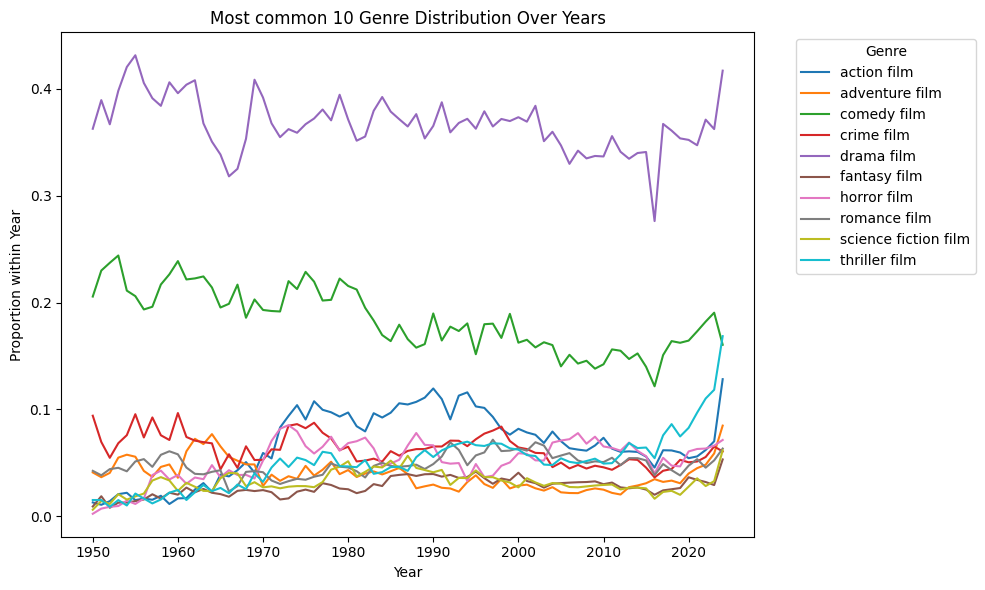

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_df = genre_counts[genre_counts.genre.isin(top_10_genres)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=temp_df,
    x='year',
    y='normalized_counts',
    hue='genre',
)

plt.title("Most common 10 Genre Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Proportion within Year")
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
### Net change in normalized counts for genres
# Compute change from first to last year for each genre
start_end_change = (
    genre_counts.sort_values('year')
          .groupby('genre')['normalized_counts']
          .agg(lambda x: x.iloc[-1] - x.iloc[0])
          .reset_index(name='net_change')
          .sort_values(by="net_change", ascending=False)
)


In [25]:
top_10_growing_genres_by_net_change = start_end_change.iloc[:10]
top_10_growing_genres_by_net_change

,genre,net_change
963,thriller film,0.153371
129,action film,0.115389
518,horror film,0.069114
824,science fiction film,0.055659
356,drama film,0.054399
205,biographical film,0.049460
264,comedy drama,0.046275
419,fantasy film,0.044035
142,adventure film,0.043838
504,historical film,0.036743


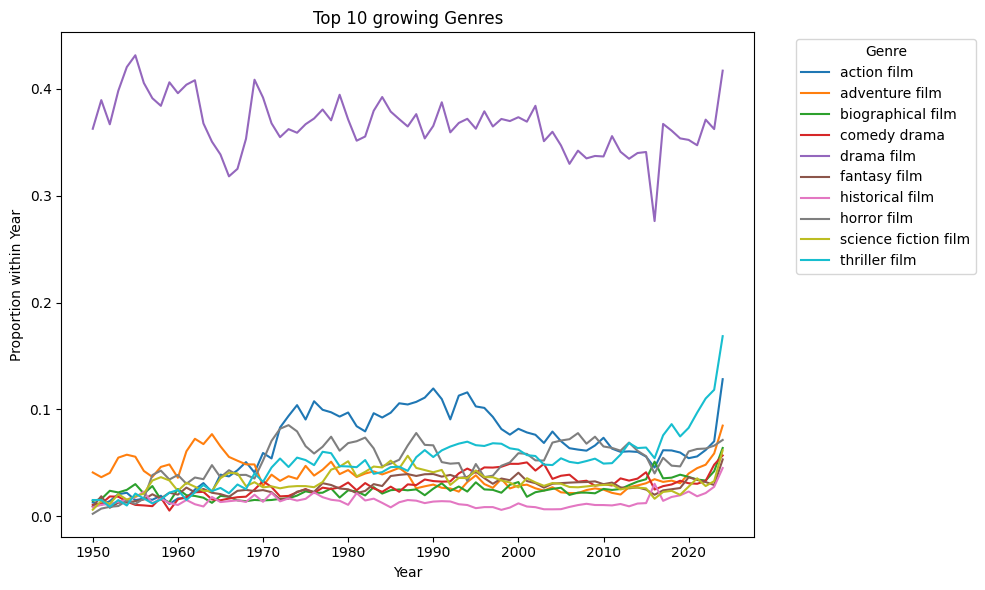

In [26]:
temp_df = genre_counts[genre_counts.genre.isin(top_10_growing_genres_by_net_change.genre)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=temp_df,
    x='year',
    y='normalized_counts',
    hue='genre',
)

plt.title("Top 10 growing Genres")
plt.xlabel("Year")
plt.ylabel("Proportion within Year")
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
top_10_declining_genres_by_net_change = start_end_change.tail(10)
top_10_declining_genres_by_net_change

,genre,net_change
443,flashback film,-0.003443
94,Rumberas film,-0.003696
927,swashbuckler film,-0.004681
1001,war film,-0.005048
435,film based on literature,-0.006530
317,crime film,-0.033427
618,musical film,-0.035320
266,comedy film,-0.045121
437,film noir,-0.069395
115,Western film,-0.157887


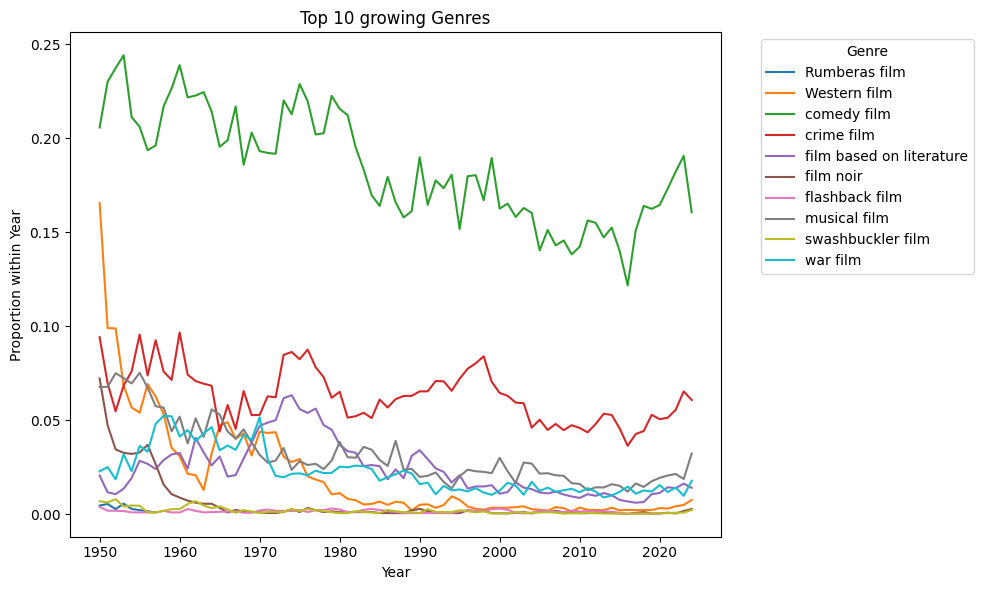

In [28]:
temp_df = genre_counts[genre_counts.genre.isin(top_10_declining_genres_by_net_change.genre)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=temp_df,
    x='year',
    y='normalized_counts',
    hue='genre',
)

plt.title("Top 10 growing Genres")
plt.xlabel("Year")
plt.ylabel("Proportion within Year")
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
### Total absolute change (most volatile)
# Compute sum of absolute year-to-year differences for each genre
total_abs_change = (
    genre_counts.sort_values('year')
          .groupby('genre')['normalized_counts']
          .agg(lambda x: (x.diff().abs().sum()))
          .reset_index(name='total_abs_change')
          .sort_values(by="total_abs_change", ascending=False)
)


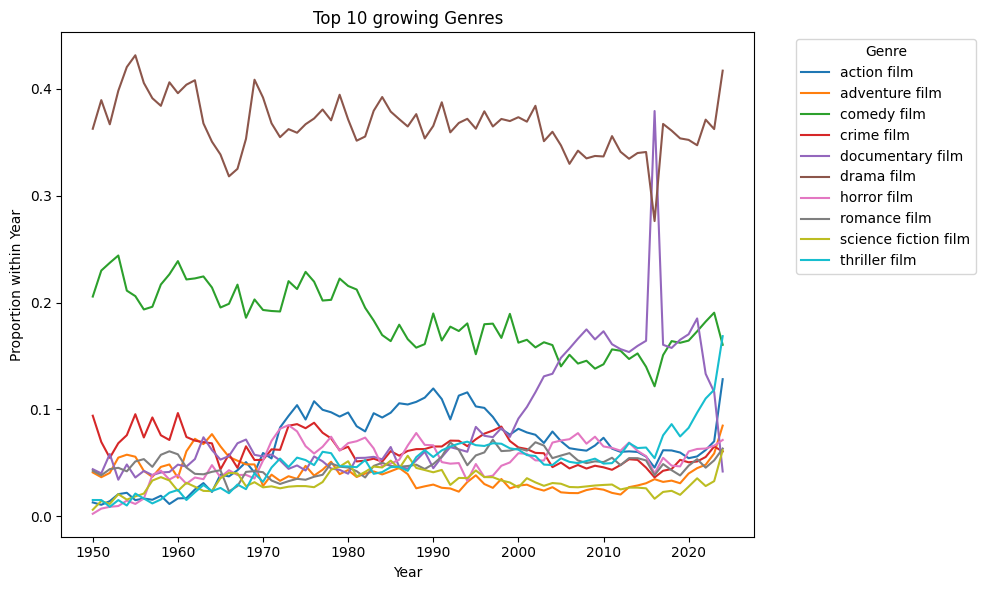

In [30]:
temp_df = genre_counts[genre_counts.genre.isin(total_abs_change.head(10).genre)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=temp_df,
    x='year',
    y='normalized_counts',
    hue='genre',
)

plt.title("Top 10 growing Genres")
plt.xlabel("Year")
plt.ylabel("Proportion within Year")
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Embeddings with Genres

In [31]:
import umap

/Users/nselcheung/opt/anaconda3/envs/data_literacy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
def genre_in_raw_genre(genre: str, genres: np.ndarray) -> bool:
    for g in genres:
        if g in genre:
            return True
        
    return False

In [33]:
top_30_genres = [i[0] for i in genre_counter.most_common(30)]

In [34]:
genre_in_raw_genre('Spaghetti Western', top_30_genres)

False

In [35]:
movie_df.drop_duplicates("movie_id", inplace=True, ignore_index=True)

In [36]:
movie_df.shape

(193460, 22)

In [37]:
movie_df.movie_id.nunique()

193460

In [38]:
movie_df = movie_df[movie_df.genre.notna()].reset_index(drop=True)

In [39]:
top_30_movie_df = movie_df[movie_df.genre.apply(lambda x: genre_in_raw_genre(x, top_30_genres))]

In [40]:
id_to_embeddings_index = pd.DataFrame({"movie_id": movie_ids})

In [41]:
id_to_embeddings_index.drop_duplicates("movie_id", inplace=True, ignore_index=True)

In [42]:
id_to_embeddings_index.reset_index(inplace=True)

In [43]:
top_30_movie_df.shape

(142530, 22)

In [44]:
top_30_movie_df = pd.merge(top_30_movie_df, id_to_embeddings_index, on="movie_id", how="right")

In [45]:
top_30_movie_df.rename(columns={"index": "emb_ind"}, inplace=True)

In [46]:
top_30_movie_df.emb_ind

0              0
1              1
2              2
3              3
4              4
           ...  
144570    144570
144571    144571
144572    144572
144573    144573
144574    144574
Name: emb_ind, Length: 144575, dtype: int64

In [47]:
emb_ind = top_30_movie_df.emb_ind.values

In [48]:
emb_ind.shape

(144575,)

In [49]:
sampled_embeddings = embeddings[emb_ind]

In [50]:
reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
umap_embedding = reducer.fit_transform(sampled_embeddings)

print(f"UMAP embedding shape: {umap_embedding.shape}")

UMAP embedding shape: (144575, 2)


In [51]:
umap_embedding

array([[ 4.5086193,  1.2248139],
       [ 5.998208 ,  1.8982462],
       [12.466969 ,  3.111036 ],
       ...,
       [11.970478 ,  0.5227469],
       [ 9.274119 , -6.3069754],
       [18.85609  , -2.3419862]], shape=(144575, 2), dtype=float32)

In [53]:
top_30_movie_df["umap_x"] = umap_embedding[:, 0]
top_30_movie_df["umap_y"] = umap_embedding[:, 1]

In [57]:
top_30_genres

['drama film',
 'action film',
 'comedy film',
 'thriller film',
 'horror film',
 'adventure film',
 'science fiction film',
 'fantasy film',
 'crime film',
 'romance film',
 'film based on a novel',
 'mystery film',
 'LGBT-related film',
 'musical film',
 'comedy drama',
 'film based on literature',
 'biographical film',
 'family film',
 'teen film',
 "children's film",
 'romantic comedy',
 'war film',
 'historical film',
 'documentary film',
 'comedy horror',
 'Christmas film',
 'buddy film',
 'martial arts film',
 'dystopian film',
 'coming-of-age fiction']

In [56]:
def contains_genre(raw_genre: str, target_genre: str) -> bool:
    return target_genre in raw_genre

In [58]:
# Analyse drama genre's umap plot shifts over the years

In [64]:
top_30_movie_df = top_30_movie_df[top_30_movie_df.genre.notna()].reset_index(drop=True)

In [66]:
drama_films = top_30_movie_df[top_30_movie_df.genre.apply(lambda x: contains_genre(x, "drama film"))]

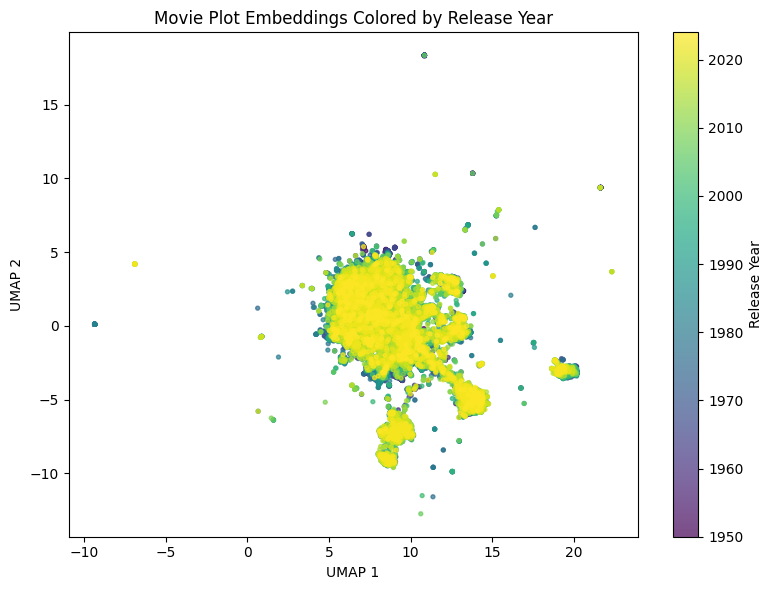

In [68]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(drama_films.umap_x, drama_films.umap_y, c=drama_films.year, cmap='viridis', s=8, alpha=0.7)
plt.colorbar(sc, label='Release Year')

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Movie Plot Embeddings Colored by Release Year")
plt.tight_layout()
plt.show()


/var/folders/3y/ktwzzwws7739qc07lxyl0k3r0000gn/T/ipykernel_37860/434307901.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


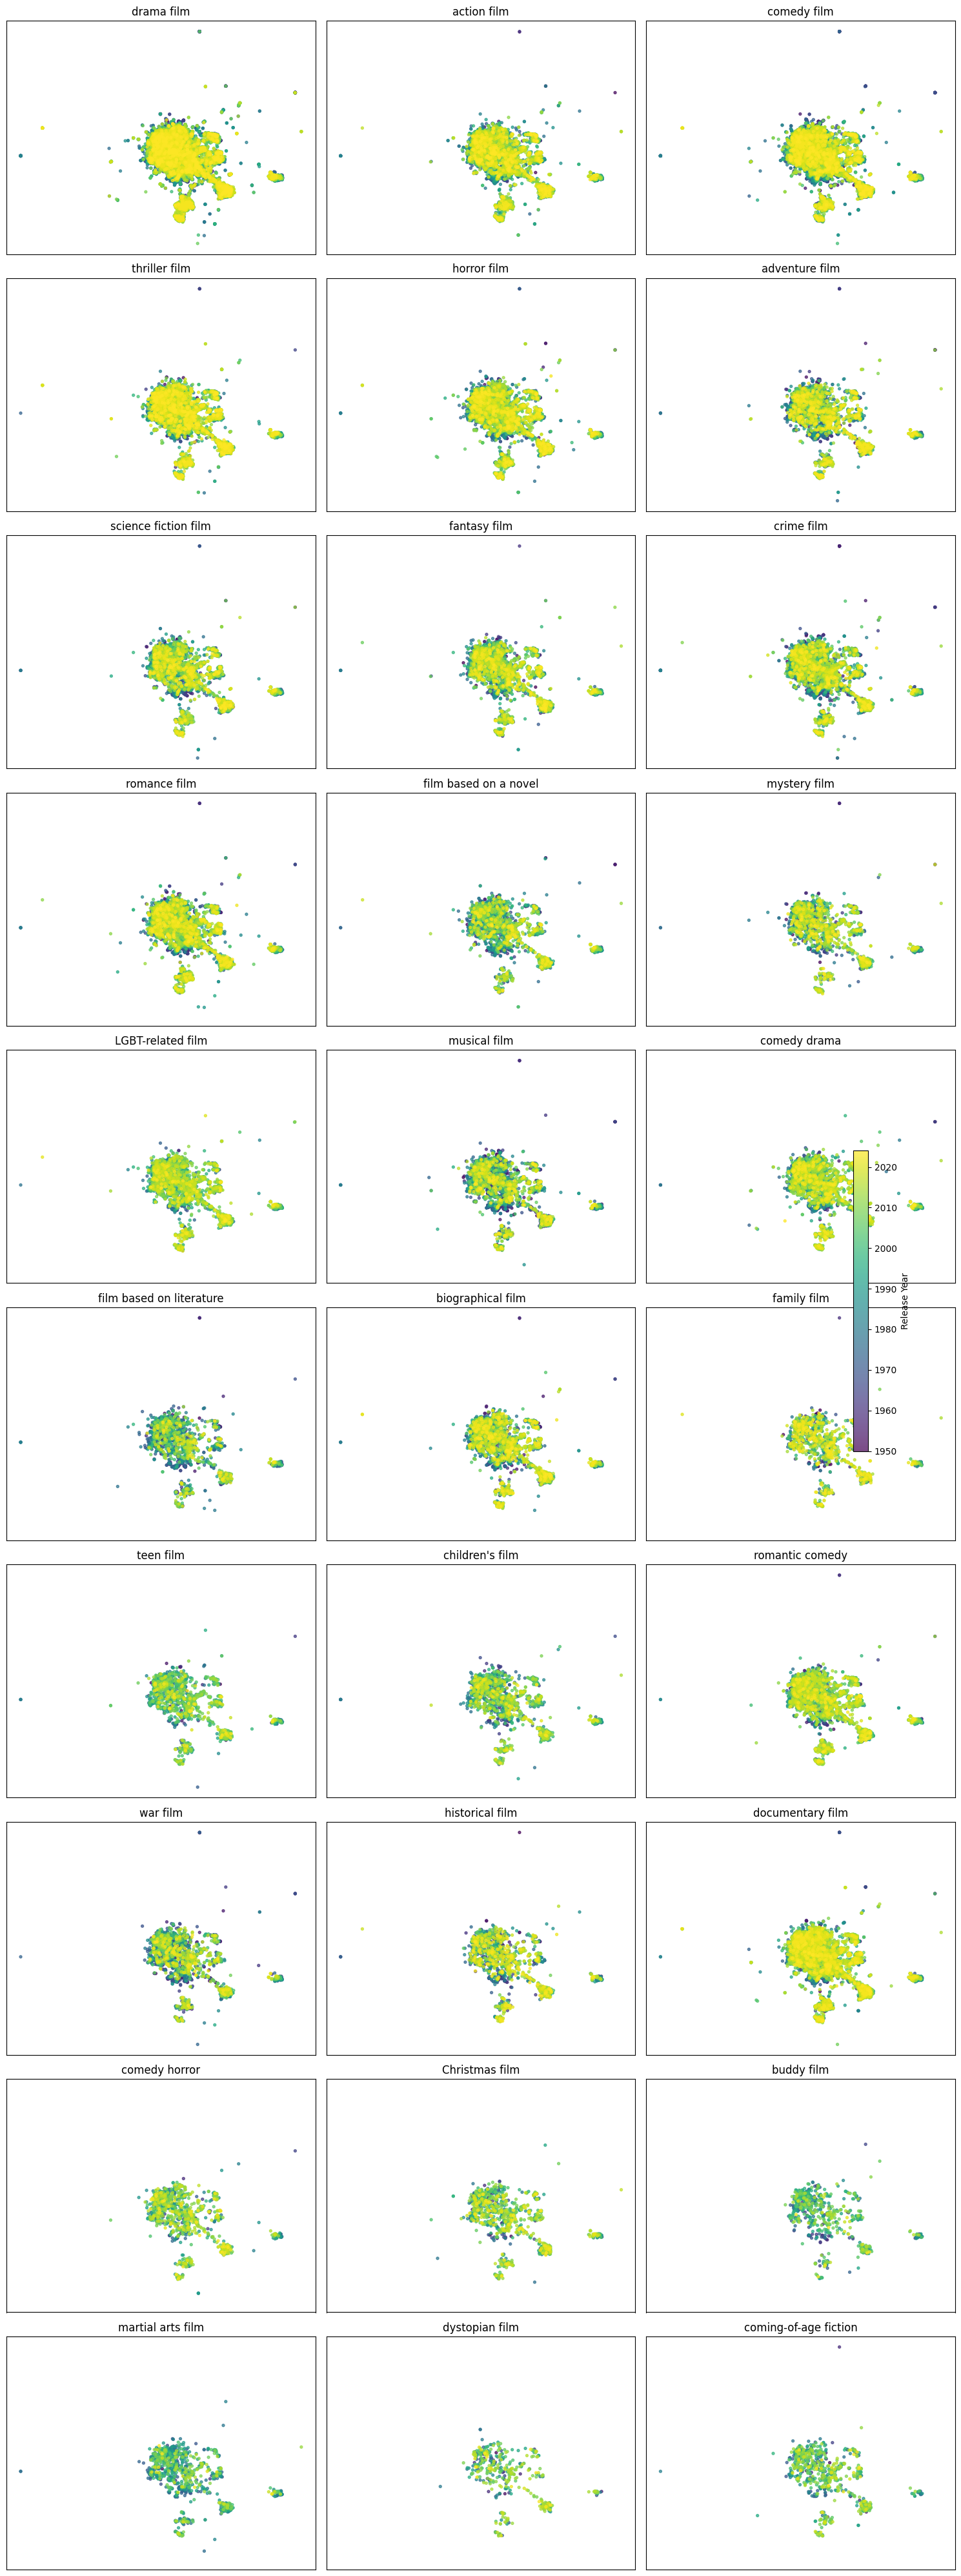

In [69]:
n_genres = 30

# Determine subplot grid size
cols = 3  # adjust as needed
rows = int(np.ceil(n_genres / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), sharex=True, sharey=True)
axes = axes.flatten()

for i, genre in enumerate(top_30_genres):
    sub_df = top_30_movie_df[top_30_movie_df.genre.apply(lambda x: contains_genre(x, genre))]
    ax = axes[i]
    sc = ax.scatter(sub_df.umap_x, sub_df.umap_y, c=sub_df.year, cmap='viridis', s=8, alpha=0.7)
    ax.set_title(genre)
    ax.set_xticks([])
    ax.set_yticks([])

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Add a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Release Year')

plt.tight_layout()
plt.show()

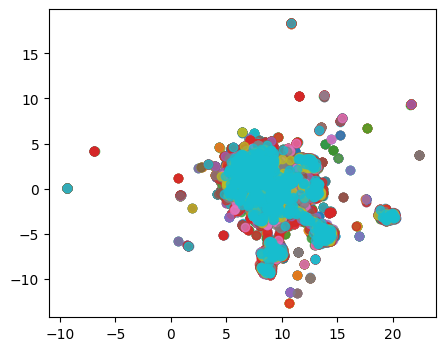

In [71]:
fig = plt.figure(figsize=(5, 4))

for i, genre in enumerate(top_30_genres):
    sub_df = top_30_movie_df[top_30_movie_df.genre.apply(lambda x: contains_genre(x, genre))]
    sc = plt.scatter(sub_df.umap_x, sub_df.umap_y, alpha=0.7)